# Analyzing Dutch restaurant reviews

## Data preparation

Before we delve into the analytical side of things, we need some prepared textual data. As all true data scientists know, proper data preparation takes most of your time and is most decisive for the quality of the analysis results you end up with. Since preparing textual data is another cup of tea compared to preparing structured numeric or categorical data, and our goal is to show you how to do text analytics, we also want to show you how we cleaned and prepared the data we gathered. Therefore, in this notebook we start with the data dump with all reviews and explore and prepare this data in a number of steps:

![](https://github.com/jads-nl/public-lectures/blob/main/nlp/text-preprocessing-pipeline.png?raw=true)

In [1]:
import pandas as pd
import pendulum


raw_reviews = pd.read_parquet("data/dutch-restaurant-reviews-per-year")
raw_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579703 entries, 0 to 2579702
Data columns (total 25 columns):
 #   Column               Dtype   
---  ------               -----   
 0   restoId              int64   
 1   restoName            object  
 2   tags                 object  
 3   address              object  
 4   scoreTotal           float64 
 5   avgPrice             object  
 6   numReviews           int64   
 7   scoreFood            float64 
 8   scoreService         float64 
 9   scoreDecor           float64 
 10  review_id            float64 
 11  numreviews2          float64 
 12  valueForPriceScore   object  
 13  noiseLevelScore      object  
 14  waitingTimeScore     object  
 15  reviewerId           float64 
 16  reviewerFame         object  
 17  reviewerNumReviews   float64 
 18  reviewDate           object  
 19  reviewScoreOverall   float64 
 20  reviewScoreFood      float64 
 21  reviewScoreService   float64 
 22  reviewScoreAmbiance  float64 
 23  reviewT

Let's look at some `reviewText`s.

In [2]:
for review in raw_reviews.reviewText.head().to_list():
    print(review + "\n")

We komen al meer dan 8 jaar in dit restaurant en we genieten elke keer van het eten dat kies.Je krijgt ook goed advies wat je wel en niet kan combineren.De bediening is uitstekend en erg vriendelijk.Ik hoop hier nog vele jaren te gaan eten.

Een werkelijk prachtige ijssalon,blinkende uitstraling met zeer vriendelijke bediening. Het ijs werd in prachtige glazen opgediend en was van een meer dan uitstekende kwaliteit. De theepotjes waren sprookjesachtig en om verliefd op te worden!Wat een aanwinst! Wat een entourage en wat een verrukkelijk ijs!

Naast dat men hier heerlijk grieks eten heeft, is iedereen er altijd uitermate vriendelijk. Je wordt altijd snel geholpen met een lach. In de zomer is het terras een aanrader, in de winter zou ik alleen maar afhalen...
Vooral de stoofschotels zijn van een hoog grieks gehalte. Het vlees is mooi gaar en heeft precies de goede structuur. De overvloed aan bijgerechten maakt het helemaal af.

Via de Sweetdeal genoten van het 3 gangenkeuzemenu, we hebb

To get a better understanding of our data, let's check the most frequent, identical review texts:

In [3]:
raw_reviews.reviewText.value_counts(normalize=True).head(20).map(lambda x: '{:,.2f}%'.format(x*100))

- Recensie is momenteel in behandeling -    0.39%
Heerlijk gegeten!                           0.10%
Heerlijk gegeten                            0.08%
Heerlijk gegeten.                           0.04%
Top                                         0.03%
Lekker gegeten                              0.02%
Prima                                       0.02%
Top!                                        0.02%
Lekker gegeten!                             0.02%
Lekker gegeten.                             0.02%
Geen                                        0.01%
.                                           0.01%
Heerlijk gegeten!!                          0.01%
Prima restaurant                            0.01%
Goed                                        0.01%
Prima!                                      0.01%
Voor herhaling vatbaar                      0.01%
Nvt                                         0.01%
Weer heerlijk gegeten!                      0.01%
Heerlijk eten!                              0.01%


Ok, several things to solve here:

- Another 0,4% has the value '- Recensie is momenteel in behandeling -' (In English: The review is currently being processed) and therefore the actual review text is not published yet. Similar to empty reviews, we can delete these reviews.
- Several reviews seem very short and are not that helpful in trying to learn from the review text. Although this is very context dependent (when performing sentiment analysis, short reviews like 'Top!' (English: Top!), 'Prima' (Engish: Fine/OK) and 'Heerlijk gegeten' (En: Had a nice meal) might still have much value!) we will set a minimum length to reviews.

Note that that reviews containing no text have already been removed from the original dataset.

### Simple filtering on text length

In [4]:
def validate_review(review):
    if review == '- Recensie is momenteel in behandeling -' or len(review) < 4:
        return 0
    else:
        return 1
    

reviews = raw_reviews.loc[:, ['restoId', 'reviewerId', 'review_id', 'reviewerFame', 'reviewerNumReviews', 'reviewText']].copy()
reviews['is_valid'] = reviews.reviewText.apply(validate_review)
reviews[reviews.is_valid==0]['reviewText'].value_counts(normalize=True).head(10)

- Recensie is momenteel in behandeling -    0.802988
Top                                         0.059768
.                                           0.022136
Nvt                                         0.015495
-                                           0.011068
..                                          0.006641
Kip                                         0.004981
nvt                                         0.004981
Ok                                          0.004981
I                                           0.003320
Name: reviewText, dtype: float64

So that looks OK, we can safely delete `is_valid == 0` reviews later. Let's do some more data prep.

### Parse localized datestrings with `pendulum`

In [5]:
pendulum.set_locale('nl')
pendulum.date(2021, 2, 12).format('D MMM YYYY')  # example

'12 feb. 2021'

In [6]:
def parse_date(date):
    return pendulum.from_format(date, fmt='D MMM YYYY', locale='nl')

reviews['reviewDate'] = raw_reviews.reviewDate.apply(parse_date).dt.date

In [7]:
reviews.reviewDate.head()

0    2012-09-19
1    2012-07-12
2    2012-11-29
3    2012-12-13
4    2012-10-19
Name: reviewDate, dtype: object

### Format numerical columns

In [8]:
# avgPrice has whitespace and euro character
def clean_price(string):
    if string:
        return string.split(" ")[-1]
    else:
        return None


reviews["avgPrice"] = raw_reviews["avgPrice"].apply(clean_price)

In [9]:
# turn categorical columns into ordinal values, lower is better
# note to Dutch audience: do you think the ordinal order is sensible and correct?
map_scores = {
    "waitingTimeScore": {
        "Hoog tempo": 1,
        "Kort": 2,
        "Redelijk": 3,
        "Kan beter": 4,
        "Lang": 5,
    },
    "valueForPriceScore": {
        "Erg gunstig": 1,
        "Gunstig": 2,
        "Redelijk": 3,
        "Precies goed": 4,
        "Kan beter": 5,
    },
    "noiseLevelScore": {
        "Erg rustig": 1,
        "Rustig": 2,
        "Precies goed": 3,
        "Rumoerig": 4,
    },
}

for col in map_scores.keys():
    reviews[col] = (
        raw_reviews[col].apply(lambda x: map_scores[col].get(x, None)).astype("Int64")
    )

In [10]:
# numerical columns have comma as decimal seperator --> cast to floats
numerical_cols = [
    "scoreFood",
    "scoreService",
    "scoreDecor",
    "reviewScoreOverall",
    "scoreTotal",
]
for col in numerical_cols:
    reviews[col] = pd.to_numeric(raw_reviews[col])

In [11]:
reviews.head()

restoId   reviewerId  review_id    reviewerFame  reviewerNumReviews  \
0   236127  111373143.0       20.0     Fijnproever                 4.0   
1   246631  111355027.0       11.0  Meesterproever                21.0   
2   243427  112961389.0        3.0   Expertproever                 9.0   
3   234077  111347867.0      107.0  Meesterproever                97.0   
4   240845  112167929.0       14.0  Meesterproever                40.0   

                                          reviewText  is_valid  reviewDate  \
0  We komen al meer dan 8 jaar in dit restaurant ...         1  2012-09-19   
1  Een werkelijk prachtige ijssalon,blinkende uit...         1  2012-07-12   
2  Naast dat men hier heerlijk grieks eten heeft,...         1  2012-11-29   
3  Via de Sweetdeal genoten van het 3 gangenkeuze...         1  2012-12-13   
4  Vakantieveiling is een leuk ding om restaurant...         1  2012-10-19   

  avgPrice  waitingTimeScore  valueForPriceScore  noiseLevelScore  scoreFood  \
0       35              <NA>                <NA>             <NA>        8.6   
1     None              <NA>                <NA>             <NA>        8.2   
2     None              <NA>                <NA>             <NA>        NaN   
3       45              <NA>                <NA>             <NA>        8.0   
4       43              <NA>                <NA>             <NA>        7.3   

   scoreService  scoreDecor  reviewScoreOverall  scoreTotal  
0           8.4         7.2                 8.5         8.4  
1           7.6         8.0                10.0         8.0  
2           NaN         NaN                 8.0         NaN  
3           8.0         7.6                 7.0         7.9  
4           7.6         7.4                 8.5         7.4

### Exercise: perform exploratory data analysis

Prior to diving into NLP with spaCy, perform a EDA to explore possible correlations:
- reviewer type vs. given scores
- length of reviews vs. scores
- value-for-money vs. scores

Learning objective:
- Lest you forget to always do a short EDA, before getting lost in details ...

## Getting started with spaCy

To develop reproducible pipelines, we will follow the recommended workflow from spaCy.

![](https://spacy.io/pipeline-fde48da9b43661abcdf62ab70a546d71.svg)

When you call `nlp` on a text, spaCy first tokenizes the text to produce a `Doc` object. The `Doc` is then processed in several different steps – this is also referred to as the __processing pipeline__. The pipeline used by the [trained pipelines](https://spacy.io/models) typically include a tagger, a lemmatizer, a parser and an entity recognizer. Each pipeline component returns the processed `Doc`, which is then passed on to the next component.

The tokenizer is a “special” component and isn’t part of the regular pipeline. It also doesn’t show up in `nlp.pipe_names`. The reason is that there can only really be one tokenizer, and while all other pipeline components take a `Doc` and return it, the tokenizer takes a __string of text__ and turns it into a `Doc`. You can still customize the tokenizer, though. `nlp.tokenizer` is writable, so you can either create your own [`Tokenizer` class from scratch](https://spacy.io/usage/linguistic-features#native-tokenizers), or even replace it with an [entirely custom function](https://spacy.io/usage/linguistic-features#custom-tokenizer).

We will use the large Dutch model which is 546 MB in size. The download command needs to be run once on your system. You may want to restart your Jupyter Notebook kernel to ensure spaCy is loaded properly with the newly downloaded model.

In [12]:
# !python -m spacy download nl_core_news_lg

In [13]:
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy


nlp = spacy.load("nl_core_news_lg")

We will show different options of tokenizing, see [this blog by Dataquest](https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/) for more details.

### Documents in spaCy

In [14]:
# create spaCy doc from one of the reviews
example_doc = nlp(reviews.reviewText[100])

# Doc object has 51 attributes and methods
print(f"Methods and attributes of spaCy Doc object: {[attr for attr in dir(example_doc) if not '__' in attr]}")

Methods and attributes of spaCy Doc object: ['_', '_bulk_merge', '_get_array_attrs', '_py_tokens', '_realloc', '_vector', '_vector_norm', 'cats', 'char_span', 'copy', 'count_by', 'doc', 'ents', 'extend_tensor', 'from_array', 'from_bytes', 'from_dict', 'from_disk', 'from_docs', 'get_extension', 'get_lca_matrix', 'has_annotation', 'has_extension', 'has_unknown_spaces', 'has_vector', 'is_nered', 'is_parsed', 'is_sentenced', 'is_tagged', 'lang', 'lang_', 'mem', 'noun_chunks', 'noun_chunks_iterator', 'remove_extension', 'retokenize', 'sentiment', 'sents', 'set_ents', 'set_extension', 'similarity', 'spans', 'tensor', 'text', 'text_with_ws', 'to_array', 'to_bytes', 'to_dict', 'to_disk', 'to_json', 'to_utf8_array', 'user_data', 'user_hooks', 'user_span_hooks', 'user_token_hooks', 'vector', 'vector_norm', 'vocab']


In [15]:
# visualize named entities
spacy.displacy.render(example_doc, style='ent')

In [16]:
# visualize dependencies
spacy.displacy.render(example_doc, jupyter=True, style='dep')

### Tokens in spaCy

In [17]:
# example_doc holds all tokens
print(f"Length of example doc: {len(example_doc)}")

# which you can access as a list
print(f"First token example doc: {example_doc[0]}")

# each token is a spaCy Token object with 90 methods and attributes
token_attrs = [attr for attr in dir(example_doc[0]) if not '__' in attr]
print(f"Each token is a {type(example_doc[0])} with 90 attributes:")
print(token_attrs)

Length of example doc: 84
First token example doc: We
Each token is a <class 'spacy.tokens.token.Token'> with 90 attributes:
['_', 'ancestors', 'check_flag', 'children', 'cluster', 'conjuncts', 'dep', 'dep_', 'doc', 'ent_id', 'ent_id_', 'ent_iob', 'ent_iob_', 'ent_kb_id', 'ent_kb_id_', 'ent_type', 'ent_type_', 'get_extension', 'has_dep', 'has_extension', 'has_head', 'has_morph', 'has_vector', 'head', 'i', 'idx', 'iob_strings', 'is_alpha', 'is_ancestor', 'is_ascii', 'is_bracket', 'is_currency', 'is_digit', 'is_left_punct', 'is_lower', 'is_oov', 'is_punct', 'is_quote', 'is_right_punct', 'is_sent_end', 'is_sent_start', 'is_space', 'is_stop', 'is_title', 'is_upper', 'lang', 'lang_', 'left_edge', 'lefts', 'lemma', 'lemma_', 'lex', 'lex_id', 'like_email', 'like_num', 'like_url', 'lower', 'lower_', 'morph', 'n_lefts', 'n_rights', 'nbor', 'norm', 'norm_', 'orth', 'orth_', 'pos', 'pos_', 'prefix', 'prefix_', 'prob', 'rank', 'remove_extension', 'right_edge', 'rights', 'sent', 'sent_start', 'sent

In [18]:
# let's view token attributes we want to use
pd.DataFrame(
    [
        (
            token.text,
            token.lower_,
            token.lemma_,
            token.shape_,
            token.is_alpha,
            token.is_stop,
            token.is_punct,
            token.tag_,
        )
        for token in example_doc
    ],
    columns=[
        "text",
        "lower_",
        "lemma_",
        "shape_",
        "is_alpha",
        "is_stop",
        "is_punct",
        "tag_",
    ],
)

text      lower_      lemma_ shape_  is_alpha  is_stop  is_punct  \
0           We          we          we     Xx      True     True     False   
1        kozen       kozen      kiezen   xxxx      True    False     False   
2         voor        voor        voor   xxxx      True     True     False   
3          dit         dit         dit    xxx      True     True     False   
4   restaurant  restaurant  restaurant   xxxx      True    False     False   
..         ...         ...         ...    ...       ...      ...       ...   
79          in          in          in     xx      True     True     False   
80   positieve   positieve    positief   xxxx      True    False     False   
81         zin         zin         zin    xxx      True    False     False   
82           )           )           )      )     False    False      True   
83           .           .           .      .     False    False      True   

                                    tag_  
0           VNW|pers|pron|nomin|red|1|mv  
1                          WW|pv|verl|mv  
2                                VZ|init  
3   VNW|aanw|det|stan|prenom|zonder|evon  
4              N|soort|ev|basis|onz|stan  
..                                   ...  
79                               VZ|init  
80           ADJ|prenom|basis|met-e|stan  
81            N|soort|ev|basis|zijd|stan  
82                                   LET  
83                                   LET  

[84 rows x 8 columns]

### Simple tokenizer

In [19]:
def tokenize_simple(text):
    """Tokenizer returning lowercase tokens with no stop words, no punctuation and no words with encoding errors"""
    doc = nlp(text)
    return [token.lower_ for token in doc if not (token.is_stop or token.is_punct or ("\\" in token.lower_))]

tokenize_simple(reviews.reviewText[100])

['kozen',
 'restaurant',
 'vieren',
 'absoluut',
 'gelukt',
 '4-gangen',
 'verrassingsmenu',
 'voorafgegaan',
 'twee',
 'amuses',
 'vóór',
 'dessert',
 'kregen',
 'prédessert',
 'wijnarrangement',
 'beroerd',
 'geschonken',
 'kortom',
 'weet',
 'klant',
 'watten',
 'leggen',
 'voelt',
 'echt',
 'gast',
 'eten',
 'heerlijk',
 'bood',
 'randstedelijke',
 'ogen',
 'absurde',
 'prijs-kwaliteitsverhouding',
 'positieve',
 'zin']

### Using lemmas as tokens

In [20]:
def tokenize_lemma(text):
    """Tokenizer returning lemmas with no stop words, no punctuation and no words with encoding errors"""
    doc = nlp(text)
    return [token.lemma_ for token in doc if not (token.is_stop or token.is_punct or ("\\" in token.lower_))]

tokenize_lemma(reviews.reviewText[100])

['kiezen',
 'restaurant',
 'vieren',
 'absoluut',
 'lukken',
 '4-gangen',
 'verrassingsmenu',
 'voorafgaan',
 'twee',
 'amuse',
 'vóór',
 'dessert',
 'krijgen',
 'prédessert',
 'wijnarrangement',
 'beroerd',
 'schenken',
 'kortom',
 'weten',
 'klant',
 'watten',
 'leggen',
 'voelen',
 'echt',
 'gast',
 'eten',
 'heerlijk',
 'bieden',
 'randstedelijk',
 'oog',
 'absurd',
 'prijs-kwaliteitsverhouding',
 'positief',
 'zin']

### Exercises

Since it takes quite some computing power to process all reviews, it is suggested to do the exercises just for a given year.

#### Remove accents in the tokens such that `vóór` is tokenized as `voor` 

#### Explore association between overall review score and length of text

#### Extract ADJ-NOUN bigrams from the text

Imagine you are advising the owner of a restaurant. We wants to mine the reviews to find specific improvement points. Assuming that ADJECTIVE - NOUN bigrams can provide useful input, for example 'oude servies', 'lange wachttijd', your task is to:
- Extract ADJ-NOUN bigrams for each review
- Find the most interesting bigrams for positive and negative reviews per restaurant

## Document-Term Matrix


### Unigrams and bag-of-words
Use `sklearn.feature_extraction.text.CountVectorizer` to create the DTM. Since this is a large and sparse matrix, this data is a [`scipy.sparse.spmatrix` object](https://docs.scipy.org/doc/scipy/reference/sparse.html) instead of a pandas dataframe. We will use the spaCy's `Defaults.stop_words`. Since creating the DTM for all reviews takes a long time, we will test it first with just 1,000 records

In [21]:
%%time
count_vectorizer = CountVectorizer(tokenizer=tokenize_simple, stop_words=nlp.Defaults.stop_words, ngram_range=(1,1))
count_vectorizer.fit_transform(reviews.reviewText[:1000])

/home/dkapitan/.local/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['t', '’n'] not in stop_words.
  warnings.warn(


CPU times: user 26.9 s, sys: 19.4 ms, total: 26.9 s
Wall time: 26.9 s


<1000x8282 sparse matrix of type '<class 'numpy.int64'>'
	with 37103 stored elements in Compressed Sparse Row format>

That's an interesting warning. Let's look at the stopwords that we have used.

In [22]:
print(list(nlp.Defaults.stop_words))

['daarom', 'hierbeneden', 'toen', 'of', 'hebt', 'min', 'ieder', 'na', 'voordat', 'iets', 'onze', 'der', 'werden', 'voorbij', 'bijna', 'weer', 'voorheen', 'op', 'in', 'beiden', 'rond', 'nr', 'tegen', 'want', 'welk', 'mij', 'den', 'zonder', 'dezen', 'zulks', 'net', 'doch', 'en', 'gedurende', 'onder', 'zelfs', 'behalve', 'gauw', 'wel', 'met', 'daarnet', 'allen', 'daar', 'geen', 'vooraf', 'van', 'heb', 'bijvoorbeeld', 'vaak', 'geweest', 'ook', 'hem', 'ondertussen', 'sommige', 'bovenal', 'later', 'ikke', 'hebben', 'voordien', 'gekund', 'achterna', 'echter', 'effe', 'zulke', 'hoe', 'onszelf', 'buiten', 'eveneens', 'dien', 'vanuit', 'alhoewel', 'vroeg', 'overigens', 'binnen', 'te', 'vanaf', 'dat', 'tussen', 'achter', 'des', 'doorgaand', 'elk', 'hij', 'zo', 'beter', 'lang', 'zoals', 'erdoor', 'hun', 'etc', 'waren', 'andere', 'nog', 'af', 'gegeven', 'dus', 'totdat', 'geven', 'ongeveer', 'zichzelf', 'omver', 'mezelf', 'jouw', 'doen', 'anders', 'meer', 'toe', 'zo’n', 'vrij', 'pas', 'er', 'anderen

So what happens here is:
- spaCy tokenizes, for example, the stop word `zo'n` into `[zo, ', n]`
- since we have chosen to remove punctuation we end up with `[zo, n]` as the tokens of the original stop word
- `zo` was already in the list of stop words, but `n` isn't which is what the warning is about

Adding those two fixes the warning, so now we can move on to actually calculate the most frequent words.

In [23]:
%%time
stop_words = nlp.Defaults.stop_words.update(['n', 't'])
count_vectorizer = CountVectorizer(tokenizer=tokenize_simple, stop_words=stop_words, ngram_range=(1,1))
bow = count_vectorizer.fit_transform(reviews.reviewText[:1000]) # just 1,000 reviews for demonstration

CPU times: user 15.2 s, sys: 3.85 ms, total: 15.2 s
Wall time: 15.2 s


Let's inspect the most frequent unigrams.

In [24]:
unigrams = pd.Series(bow.sum(axis=0).A1.transpose().ravel(), index=count_vectorizer.get_feature_names())
unigrams.sort_values(ascending=False)

/home/dkapitan/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


\n                945
eten              626
bediening         573
goed              546
erg               450
                 ... 
onderhoud           1
onderhand           1
ondergetekende      1
eetgewoontes        1
5,50                1
Length: 8282, dtype: int64

### TF-IDF
In the same vein, we could use the `TfidfVectorizer`. While we are at it, let's include bigrams, too.

In [25]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize_simple, stop_words=stop_words, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(reviews.reviewText[:1000])

Let's see which words have the highest TF-IDF per document.

In [26]:
rare_bigrams = pd.Series([tfidf_vectorizer.get_feature_names()[i] for i in tfidf.A.argmax(axis=1)])
rare_bigrams.head(40)

0                    8 jaar
1                 prachtige
2                    grieks
3                         4
4                uur rijden
5                        \n
6                       uur
7                  iegewies
8                2 desserts
9                   broodje
10             aandoet oude
11                   6 euro
12                   gangen
13                      wok
14               \n maarrrr
15                     ribs
16          groupon voucher
17                    17,95
18               broodjemet
19                    bezig
20                 2-jarige
21                     soep
22             correct soms
23                    2 ker
24          achterin lounge
25    bediening fantastisch
26            attent genoeg
27                     ruim
28                    soort
29                  izakaya
30                      bar
31           kabouterhappen
32                    rijst
33             attente soms
34                      top
35              groe

Interesting to read a review mentioning 'kabouterhappen':

In [27]:
print(reviews.reviewText[31])

Ik had me erg verheugd op ons etentje bij Izakaya. De aankleding  van het restaurant ziet er veelbelovend uit. Ik dacht eindelijk een 'place to be' in de Pijp. Bij de reservering kreeg ik al een naar gevoel; de tafel was beschikbaar van 19.00 tot 21.00 uur. De eerste indruk bij binnenkomst was prima, aardige bediening, leuke tafel. Wel veel trendy dertigers en typisch Oud-Zuid publiek.     We hebben meerdere ronde hapjes bestelt, sommige echt lekker, andere middelmatig. Wat met name teleurstelde, was de hoeveelheid. We zijn geen grote eters, maar dit waren echt kabouterhappen. De grootste tegenvaller kwam achteraf; de rekening. Duurbetaalde kabouterhappen. We waren met 4 mensen ruim €280,- kwijt. In deze prijsklasse ken ik veel betere restaurants in Amsterdam. Als Izakaya de porties een beetje groter maakt en de prijzen een beetje kleiner, is er hoop.


We will use the document-term matrix, with either simple counts or with TF-IDF, later on in our classification pipeline.

## Topic modeling

### Combining DTM with LDA

The [sklearn example on topic modeling](https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html?highlight=topic%20modeling) shows how to setup a pipeline for topic modeling. We will follow along with the same parameter settings and [use pyLDAvis](https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/sklearn.ipynb) to visualize our results.

In [28]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn


pyLDAvis.enable_notebook()

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20

In [29]:
%%time
tfidf_vectorizer2 = TfidfVectorizer(
    max_df=0.95,
    min_df=2,
    max_features=n_features,
    tokenizer=tokenize_simple,
    stop_words=stop_words,
    strip_accents='unicode',
    ngram_range=(1, 2),
)
dtm_tfidf = tfidf_vectorizer2.fit_transform(reviews.reviewText[:n_samples])

/home/dkapitan/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 38.5 s, sys: 11.5 ms, total: 38.5 s
Wall time: 38.5 s


In [30]:
%%time
lda_tfidf = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=0,
).fit(dtm_tfidf)

/home/dkapitan/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 1.63 s, sys: 43 µs, total: 1.63 s
Wall time: 1.63 s


In [31]:
pyLDAvis.sklearn.prepare(lda_tfidf, dtm_tfidf, tfidf_vectorizer2)

/home/dkapitan/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dkapitan/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/dkapitan/.local/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.063017  0.000165       1        1  83.935837
0      0.018652  0.023422       2        1   1.870450
8      0.019957 -0.020877       3        1   1.855720
9      0.000533 -0.000219       4        1   1.762571
3      0.002471 -0.000630       5        1   1.762571
5      0.002330 -0.000311       6        1   1.762571
7      0.003928 -0.000366       7        1   1.762570
4      0.004860 -0.000398       8        1   1.762570
1      0.005107 -0.000377       9        1   1.762570
6      0.005180 -0.000409      10        1   1.762570, topic_info=          Term        Freq       Total Category  logprob  loglift
0           \n  109.000000  109.000000  Default  30.0000  30.0000
232        erg   64.000000   64.000000  Default  29.0000  29.0000
14               40.000000   40.000000  Default  28.0000  28.0000
536     lekker   65.000000   65.000000  Default  27.0000  27.0000
362       goed   78.000000   78.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
292   gebakken    0.178729   14.486416  Topic10  -6.8157  -0.3567
536     lekker    0.181263   65.219617  Topic10  -6.8016  -1.8472
300    gegeten    0.179498   61.190189  Topic10  -6.8114  -1.7932
88   bediening    0.179443   71.145700  Topic10  -6.8117  -1.9442
97      beetje    0.178851   25.539629  Topic10  -6.8150  -0.9230

[761 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.983922          \n
3         1  0.540648    \n decor
4         1  0.562419  \n dessert
5         1  0.710313      \n erg
11        1  0.669525    \n prijs
...     ...       ...         ...
988       1  0.823713        zo'n
991       1  0.655971      zoeken
992       1  0.650947        zoet
993       1  0.722876       zoete
999       1  0.891373           €

[382 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 9, 10, 4, 6, 8, 5, 2, 7])

### Second iteration topic model

The results from the topic model are not really useful: frequent occuring words are included in many topics, resulting in overlapping topics. Following the [approach from the Analytics Lab](https://www.theanalyticslab.nl/nlpblogs_1_identifying_topics_using_topic_-modeling_lda/) we will second topic model which uses a simple `CountVectorizer` including only words that occur in 5 or more documents. 

In [32]:
%%time
count_vectorizer2 = CountVectorizer(
    min_df=5,
    max_features=n_features,
    tokenizer=tokenize_simple,
    stop_words=stop_words,
    strip_accents='unicode',
    ngram_range=(1, 2),
)
dtm_tf2 = count_vectorizer2.fit_transform(reviews.reviewText[:n_samples])

/home/dkapitan/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 33.8 s, sys: 55.6 ms, total: 33.8 s
Wall time: 33.8 s


In [33]:
%%time
lda_tf2 = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    learning_method="online",
    learning_offset=50.0,
    random_state=42,
).fit(dtm_tf2)

/home/dkapitan/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


CPU times: user 3.67 s, sys: 0 ns, total: 3.67 s
Wall time: 3.67 s


In [34]:
pyLDAvis.sklearn.prepare(lda_tf2, dtm_tf2, count_vectorizer2)

/home/dkapitan/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/dkapitan/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/home/dkapitan/.local/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.020935  0.004336       1        1  51.843897
9      0.078633  0.013869       2        1  21.010391
3      0.110361  0.054793       3        1  18.969666
1      0.083433 -0.222620       4        1   2.624485
6      0.139548  0.125645       5        1   2.403023
5     -0.169570  0.060030       6        1   1.031827
8     -0.019611  0.008833       7        1   0.895327
7     -0.109107 -0.027251       8        1   0.511706
0     -0.068895 -0.010214       9        1   0.381710
2     -0.065727 -0.007420      10        1   0.327967, topic_info=          Term         Freq        Total Category  logprob  loglift
0           \n  1676.000000  1676.000000  Default  30.0000  30.0000
248       eten  1281.000000  1281.000000  Default  29.0000  29.0000
89   bediening  1071.000000  1071.000000  Default  28.0000  28.0000
500      komen   302.000000   302.000000  Default  27.0000  27.0000
698      prima   555.000000   555.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
83       avond     0.236539   213.413557  Topic10  -6.6952  -1.0849
753      sfeer     0.236776   234.007882  Topic10  -6.6942  -1.1760
763      smaak     0.237384   340.201572  Topic10  -6.6916  -1.5476
27           3     0.233999   130.279821  Topic10  -6.7060  -0.6021
279       gaan     0.231459   233.583747  Topic10  -6.7169  -1.1969

[554 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         1  0.951047      \n
0         2  0.020882      \n
0         3  0.001193      \n
0         4  0.019689      \n
0         5  0.002983      \n
...     ...       ...     ...
988       3  0.028919    zo'n
988       5  0.057837    zo'n
992       1  0.947735    zoet
995       1  0.648797  zondag
995       2  0.259519  zondag

[1404 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 10, 4, 2, 7, 6, 9, 8, 1, 3])

Now that looks a lot better out-of-the-box already. Remember, like with t-sne and hierarchical clustering, LDA is a non-deterministic algorithm which will yield different results depending on the seed. Furthermore, their is no objective function that you can optimize, so it's up to you to decide what constitutes a good, i.e. useful topic model.

### Exercises

#### Improve the topic model

Play around and try to improve the topic model. You may use any of the following techniques:
- Remove frequent words by adding them to the set of stop words
- Use lemma's instead of plain tokens
- Try different `random_state`s

#### Calculate topic probabilities per review

Following the [approach of the Analytics Lab](https://www.theanalyticslab.nl/nlpblogs_3_use_topic_modeling_results_in_predictive_modeling/), calculate the topic probability per review over your chosen topic model. The topic probabilities should sum to 1.0. These topic probabilities will be used as input for the classification task.

## Classification challenge: predict detractors from text reviews

As a final exercise, combine all the different techniques we have covered so far to build a model that predicts the review score using the text. Specifically, we are interested in classifying [detractors](https://en.wikipedia.org/wiki/Net_Promoter), i.e. people that have given an overall score of 6 or lower. This is an imbalanced class problems, since only 11% of the overall reviews are detractors.

/home/dkapitan/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Percentage of detractors: 11.0%



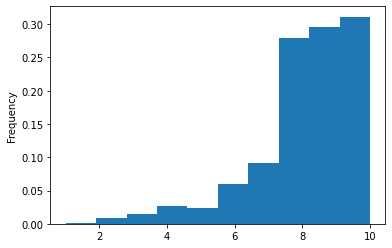

In [35]:
_ = reviews.reviewScoreOverall.value_counts(normalize=True)
print(f"Percentage of detractors: {_[_.index <= 6].sum().round(2)*100}%\n")
reviews.reviewScoreOverall.plot(kind='hist', density=True);

To make the challenge manageable, you can reduce the number of reviews included in your analysis by focusing on a particular year, or one one particular restaurant (which has enough reviews).

Finally, to help you with setting up a reproducible pipeline, an example is given below which you can use as a starting point. The use of `sklearn.base.TransformerMixin` is recommendend to integrate custom functions, like the tokenizer, into one sklearn pipeline.

In [36]:
from sklearn.pipeline import Pipeline


class tokenizer(TransformerMixin):
    def transform(self, X, **transform_params):
        return [tokenize_simple(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

/home/dkapitan/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [37]:
# TODO: add example pipeline here so students can focus on analysis without getting too much lost in technicalities
# pipeline = Pipeline(
#     [
#         ("tokenizer", tokenizer()),
#         ("dtm", dtm_tf2),
#         ("topic_model", lda_tf2),
#         ("classifier", classifier), add your classifier here
#     ]
# )

/home/dkapitan/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
